In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Keras. 

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from keras.metrics import binary_crossentropy

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("white")

## Define categorical funcion. This prepares entries for tensor analysis. 

def to_categorical(y):
    return tf.keras.utils.to_categorical(y)


In [2]:
credit_card_df = pd.read_csv("/Users/Matt/Documents/GitHub/Credit-Card-Fraud-Detection/creditcard.csv")
credit_card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Pickout the valid transactions.

valid_transactions = credit_card_df.loc[credit_card_df['Class'] == 0.0]
fraudulent_transactions = credit_card_df.drop(valid_transactions.index)

In [5]:
# Create a more balanced data set. This training set will have a ~ 50 / 50 split of valid and fraudulent transactions.
# I'll randomly sample 500 valid transactions and then add on the remaining 492 invalid transactions for a total of 
# 992. 

valid_sample = valid_transactions.sample(500)

# Shuffle the data 

sample_data_df = pd.concat([valid_sample, fraudulent_transactions])

# Set aside training/test data. 

sample_data_train = sample_data_df.sample(frac = .80, random_state = 440)
sample_data_test = sample_data_df.drop(sample_data_train.index)

sample_data_df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
128379,78691.0,-0.746779,1.505116,1.343947,0.816243,-0.009678,-0.652356,0.638391,-0.074477,-0.762524,...,0.103839,0.353751,-0.130185,0.428216,-0.214628,-0.473863,-0.388139,-0.135327,2.50,0
267777,162926.0,0.051460,0.452412,1.904973,1.287289,-0.667331,0.319326,-0.328819,0.151311,0.154859,...,0.130735,0.617479,0.039774,-0.030201,-1.056561,0.579046,0.249669,0.206833,20.16,0
187438,127534.0,-0.301117,1.158845,-0.305194,-0.455978,1.097848,-0.654858,1.201054,-0.199495,-0.076338,...,0.009227,0.414316,-0.335409,-0.691774,-0.039453,0.616717,0.378262,0.261194,29.99,0
202094,134171.0,1.980001,-0.592494,-0.087149,0.221389,-0.594701,0.582389,-1.134232,0.246151,1.755082,...,0.205524,0.791629,0.144986,0.043977,-0.253363,-0.258769,0.071834,-0.021207,14.99,0
96165,65640.0,1.387896,-0.181054,0.235886,-0.538640,-0.831615,-1.155760,-0.414336,-0.263423,-0.972633,...,-0.132594,-0.448808,0.099964,0.316828,0.269670,-0.483849,0.028270,0.047015,15.00,0


In [6]:
# Scale the data

from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

sample_data_df['scaled_amount'] = rob_scaler.fit_transform(sample_data_df['Amount'].values.reshape(-1,1))
sample_data_df['scaled_time'] = rob_scaler.fit_transform(sample_data_df['Time'].values.reshape(-1,1))

sample_data_df.drop(['Time','Amount'], axis=1, inplace=True)




In [7]:
#  Add them back in 

scaled_amount = sample_data_df['scaled_amount']
scaled_time = sample_data_df['scaled_time']

sample_data_df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
sample_data_df.insert(0, 'scaled_amount', scaled_amount)
sample_data_df.insert(1, 'scaled_time', scaled_time)

# Now the amount and time are scaled.

sample_data_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
128379,-0.151773,-0.002324,-0.746779,1.505116,1.343947,0.816243,-0.009678,-0.652356,0.638391,-0.074477,...,0.036018,0.103839,0.353751,-0.130185,0.428216,-0.214628,-0.473863,-0.388139,-0.135327,0
267777,0.027153,0.957193,0.051460,0.452412,1.904973,1.287289,-0.667331,0.319326,-0.328819,0.151311,...,0.300199,0.130735,0.617479,0.039774,-0.030201,-1.056561,0.579046,0.249669,0.206833,0
187438,0.126748,0.554044,-0.301117,1.158845,-0.305194,-0.455978,1.097848,-0.654858,1.201054,-0.199495,...,0.192834,0.009227,0.414316,-0.335409,-0.691774,-0.039453,0.616717,0.378262,0.261194,0
202094,-0.025228,0.629646,1.980001,-0.592494,-0.087149,0.221389,-0.594701,0.582389,-1.134232,0.246151,...,-0.124009,0.205524,0.791629,0.144986,0.043977,-0.253363,-0.258769,0.071834,-0.021207,0
96165,-0.025127,-0.150987,1.387896,-0.181054,0.235886,-0.538640,-0.831615,-1.155760,-0.414336,-0.263423,...,0.181081,-0.132594,-0.448808,0.099964,0.316828,0.269670,-0.483849,0.028270,0.047015,0


In [8]:
# Make sure that the Class values (i.e. the entries of y) match the sample data.
# The training data:

X_train = np.array(sample_data_train.iloc[:, :-1])
y_train = np.array(sample_data_train.iloc[:, -1])

X_train = X_train.reshape(-1, 30)
y_train = y_train.reshape(-1, 1)

# And the test data:

X_test = np.array(sample_data_test.iloc[:, :-1])
y_test = np.array(sample_data_test.iloc[:, -1])

X_test = X_test.reshape(-1, 30)
y_test = y_test.reshape(-1, 1)

In [9]:
# Further split the training data into train_train/validation. 

from sklearn.model_selection import train_test_split

X_train_train,X_val,y_train_train,y_val = train_test_split(X_train, y_train,
                                                          test_size=.2,
                                                          shuffle=True,
                                                          stratify=y_train,
                                                          random_state=440)

# Check out the shape of the data. 

print(np.shape(X_train_train), type(X_train_train))
print(np.shape(y_train_train), type(y_train_train))
print(np.shape(X_val), type(X_val))
print(np.shape(y_val), type(y_val))
print('\n\n')
print(np.shape(to_categorical(y_train_train)), type(to_categorical(y_train_train)))
print(np.shape(to_categorical(y_val)), type(to_categorical(y_val)))

(635, 30) <class 'numpy.ndarray'>
(635, 1) <class 'numpy.ndarray'>
(159, 30) <class 'numpy.ndarray'>
(159, 1) <class 'numpy.ndarray'>



(635, 2) <class 'numpy.ndarray'>
(159, 2) <class 'numpy.ndarray'>


In [10]:
## Empty model
model = models.Sequential()

In [11]:
## Make the layers. ONLY RUN THIS ONCE. Make sure the input_shape matches the number of features.

model.add(layers.Dense(30, activation='relu', input_shape=(30,)))

model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

In [12]:
# Gives a model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Here we compile the model. We use binary cross-entropy. 

model.compile(optimizer='Adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [15]:
# Fitting the data. 

#history = model.fit(X_train_train,
#                        to_categorical(y_train_train),
#                        epochs = 100,
#                        batch_size = 512,
#                        validation_data=(X_val,to_categorical(y_val)))

# It looks like sparse_categorical automatically applies to_categorical to y, so use this one
# (this includes changed batch size and epochs):

history = model.fit(X_train_train,
                        y_train_train,
                        epochs = 20,
                        batch_size = 25,
                        validation_data=(X_val,y_val))

Epoch 1/20
26/26 [==============================] - 0s 3ms/step - loss: 63.6812 - accuracy: 0.5008 - val_loss: 120.1213 - val_accuracy: 0.5535
Epoch 2/20
26/26 [==============================] - 0s 2ms/step - loss: 45.8375 - accuracy: 0.5969 - val_loss: 21.5465 - val_accuracy: 0.6667
Epoch 3/20
26/26 [==============================] - 0s 2ms/step - loss: 40.8018 - accuracy: 0.6315 - val_loss: 2.2813 - val_accuracy: 0.6604
Epoch 4/20
26/26 [==============================] - 0s 2ms/step - loss: 31.7347 - accuracy: 0.5969 - val_loss: 73.4498 - val_accuracy: 0.4906
Epoch 5/20
26/26 [==============================] - 0s 2ms/step - loss: 67.6898 - accuracy: 0.5654 - val_loss: 70.6918 - val_accuracy: 0.4906
Epoch 6/20
26/26 [==============================] - 0s 2ms/step - loss: 74.6957 - accuracy: 0.5244 - val_loss: 147.3720 - val_accuracy: 0.4906
Epoch 7/20
26/26 [==============================] - 0s 2ms/step - loss: 120.0856 - accuracy: 0.5433 - val_loss: 287.9304 - val_accuracy: 0.4906
Epo

In [72]:
# Examine the results. 

history_dict = history.history

print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


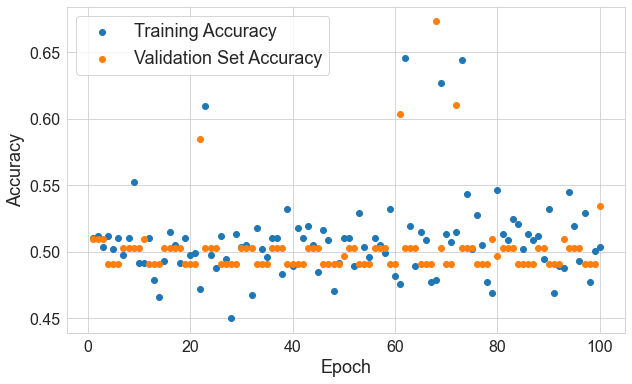

In [73]:
# That's... intersting. 

set_style("whitegrid")

plt.figure(figsize = (10,6))

plt.scatter(range(1,101), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,101), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

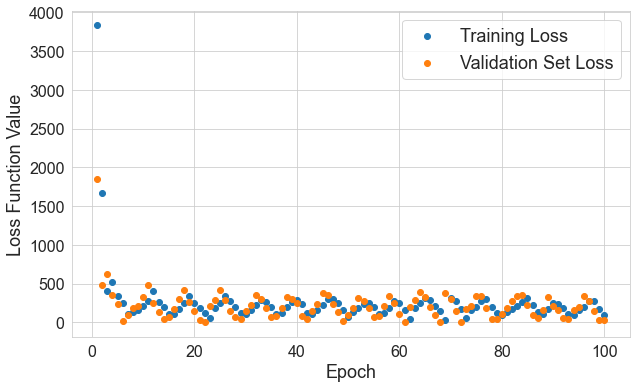

In [74]:
plt.figure(figsize = (10,6))

plt.scatter(range(1,101), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,101), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss Function Value", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

In [75]:
# Value counts of test data. 

sample_data_test.value_counts('Class')

Class
1    103
0     95
dtype: int64

In [17]:
# Prediction.

y_pred = model.predict(X_test)
y_pred

array([[1.00000000e+00, 4.28876475e-20],
       [1.00000000e+00, 8.87790674e-10],
       [1.00000000e+00, 3.57747302e-18],
       [1.00000000e+00, 1.98533852e-18],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 4.39595554e-10],
       [1.00000000e+00, 2.94550498e-15],
       [1.00000000e+00, 3.57751761e-31],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.98865102e-33],
       [1.00000000e+00, 5.33571939e-14],
       [1.00000000e+00, 7.31704364e-10],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 4.99384255e-34],
       [1.00000000e+00, 8.72912940e-12],
       [1.00000000e+00, 3.53080529e-34],
       [1.00000000e+00, 9.23105949e-12],
       [1.00000000e+00, 7.91418246e-16],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 3.85884640e-08],
       [1.00000000e+00, 2.08757165e-12],
       [1.00000000e+00, 1.07553610e-29],
       [1.00000000e+00, 4.38154829e-14],
       [1.00000000e+00, 0.00000000e+00],
       [1.000000

In [18]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))